Импорт бибилиотек

In [45]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Получение данных и их первичный анализ

In [46]:
df = pd.read_csv('data/car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [47]:
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


(              Year  Selling_Price  Present_Price     Kms_Driven       Owner
 count   301.000000     301.000000     301.000000     301.000000  301.000000
 mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
 std       2.891554       5.082812       8.644115   38886.883882    0.247915
 min    2003.000000       0.100000       0.320000     500.000000    0.000000
 25%    2012.000000       0.900000       1.200000   15000.000000    0.000000
 50%    2014.000000       3.600000       6.400000   32000.000000    0.000000
 75%    2016.000000       6.000000       9.900000   48767.000000    0.000000
 max    2018.000000      35.000000      92.600000  500000.000000    3.000000,
 None)

Пустых значений нет, посмотрим на количественные признаки

In [48]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int', 'int64'])
df_num_features.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
0,2014,3.35,5.59,27000,0
1,2013,4.75,9.54,43000,0
2,2017,7.25,9.85,6900,0
3,2011,2.85,4.15,5200,0
4,2014,4.60,6.87,42450,0


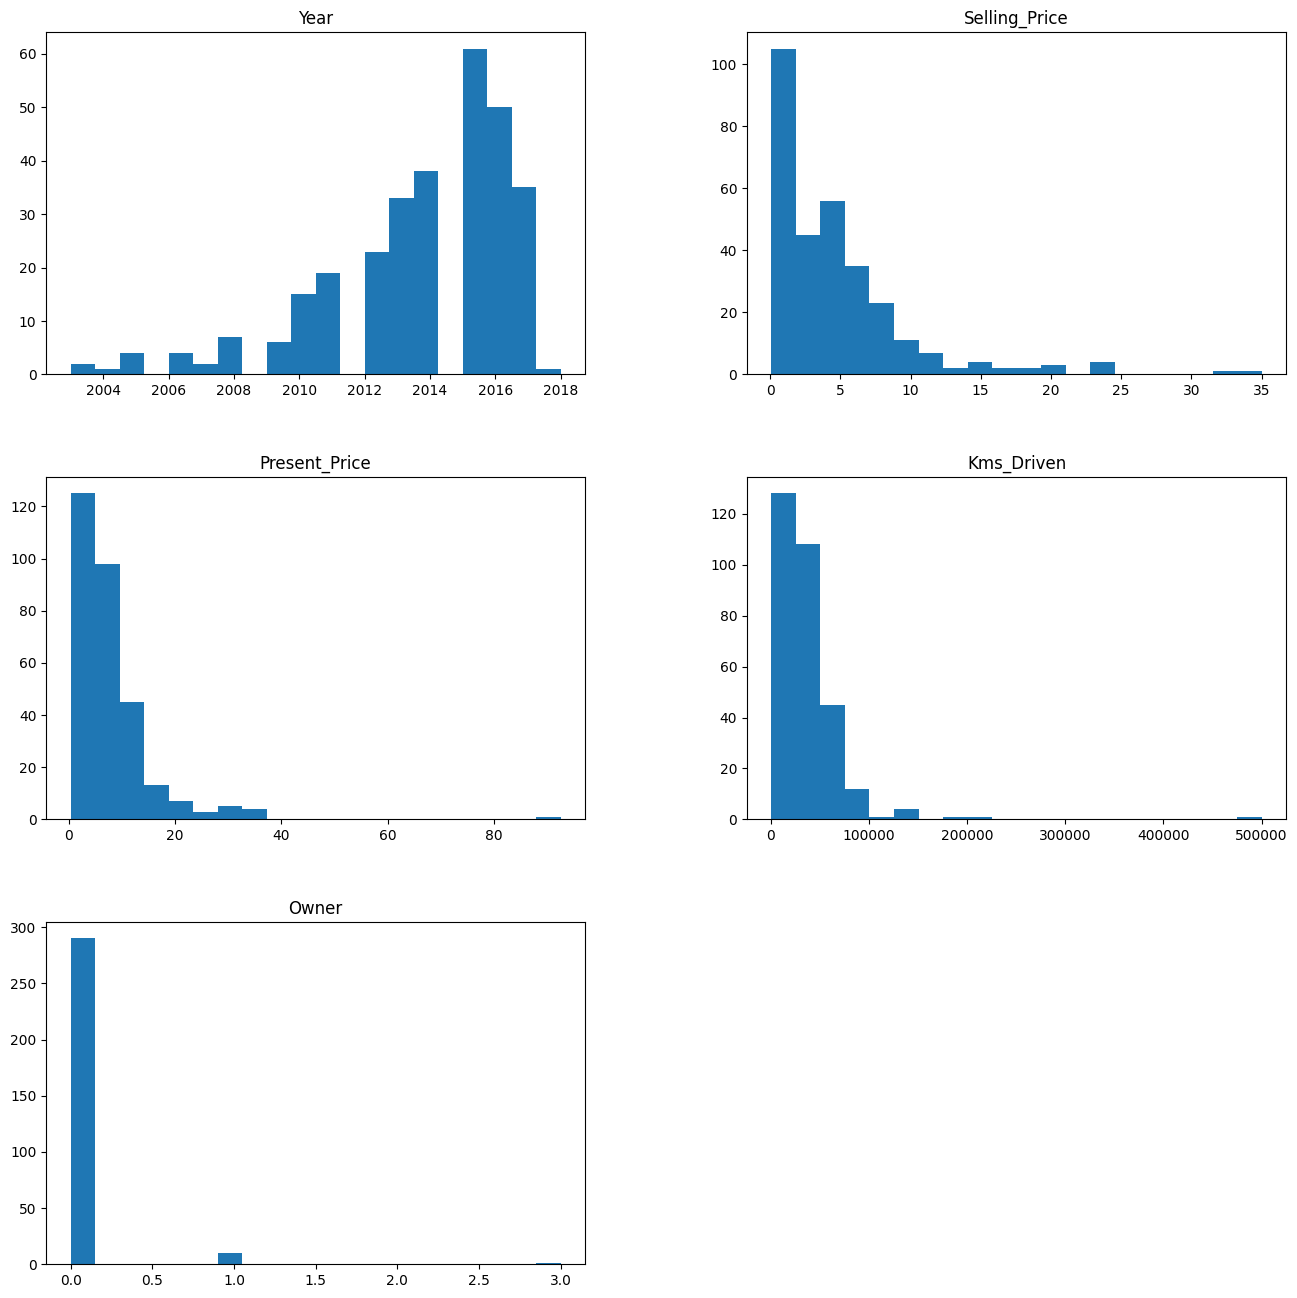

In [49]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)
plt.show()

Избавимся от выбросов

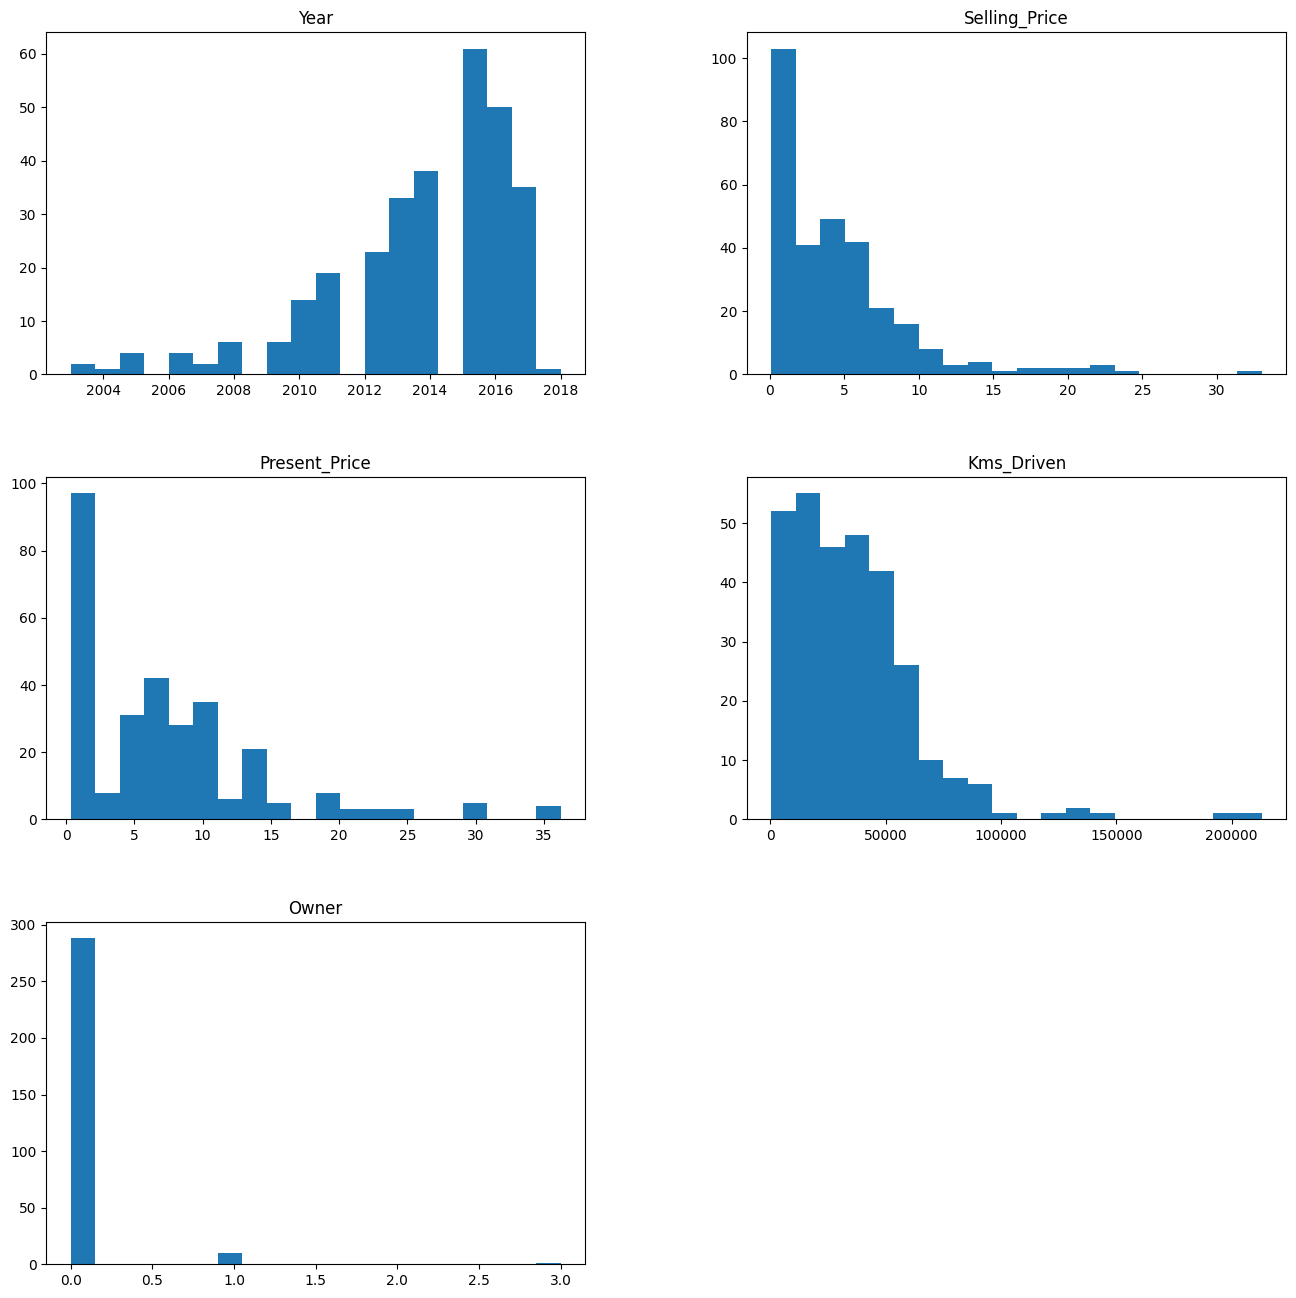

In [50]:
df = df.loc[df['Present_Price'].le(50) & df['Kms_Driven'].le(250_000)]
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int', 'int64'])
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

plt.show()

Построим матрицу корелляций

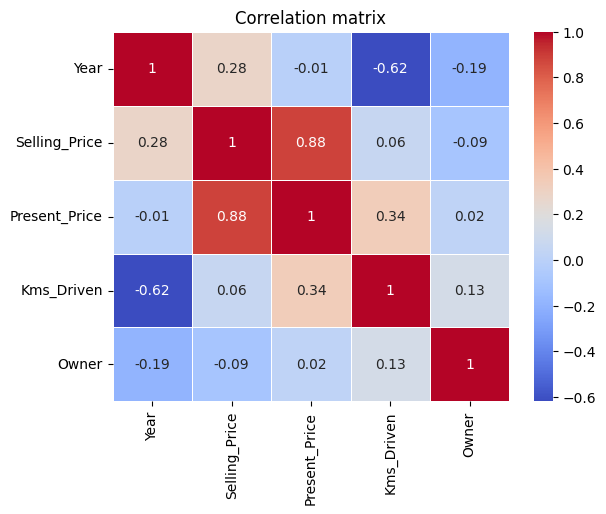

In [51]:
df_corr = df_num_features.corr()

corr_matrix = np.round(df_corr, 2)
df_corr[np.abs(df_corr) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Особо нет прямых корелляций, кроме как с Present_Price

Подумаем над качественными признаками

In [52]:
# Fuel_Type	Seller_Type	Transmission
df['Fuel_Type'].value_counts()

Fuel_Type
Petrol    238
Diesel     59
CNG         2
Name: count, dtype: int64

In [53]:
df['Seller_Type'].value_counts()

Seller_Type
Dealer        194
Individual    105
Name: count, dtype: int64

In [54]:
df['Transmission'].value_counts()

Transmission
Manual       260
Automatic     39
Name: count, dtype: int64

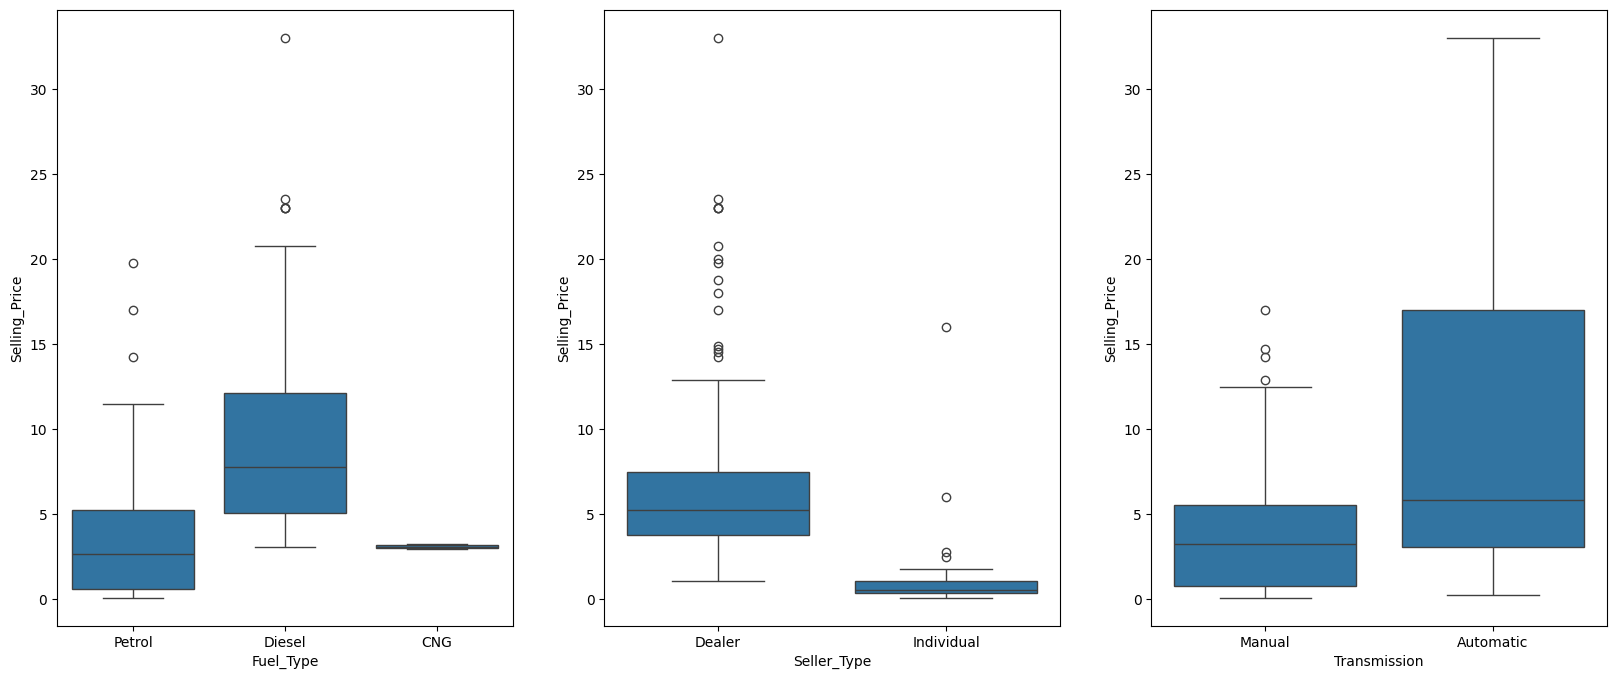

In [55]:
plt.figure(figsize=(20,8))

plt.subplot(131)
sns.boxplot(y=df['Selling_Price'], x=df['Fuel_Type'], whis=1.5)
plt.xlabel('Fuel_Type')

plt.subplot(132)
sns.boxplot(y=df['Selling_Price'], x=df['Seller_Type'], whis=1.5)
plt.xlabel('Seller_Type')

plt.subplot(133)
sns.boxplot(y=df['Selling_Price'], x=df['Transmission'], whis=1.5)
plt.xlabel('Transmission')

plt.show()

Сделаем их числовыми

In [56]:
df.loc[df['Fuel_Type'] == "Petrol", 'Fuel_Type'] = 1
df.loc[df['Fuel_Type'] == "Diesel", 'Fuel_Type'] = 2
df.loc[df['Fuel_Type'] == "CNG", 'Fuel_Type'] = 3

df['Fuel_Type'].head()

0    1
1    2
2    1
3    1
4    2
Name: Fuel_Type, dtype: object

In [57]:
df.loc[df['Seller_Type'] == "Dealer", 'Seller_Type'] = 0
df.loc[df['Seller_Type'] == "Individual", 'Seller_Type'] = 1

df['Seller_Type'].head()

0    0
1    0
2    0
3    0
4    0
Name: Seller_Type, dtype: object

In [58]:
df.loc[df['Transmission'] == "Manual", 'Transmission'] = 0
df.loc[df['Transmission'] == "Automatic", 'Transmission'] = 1

df['Transmission'].head()

0    0
1    0
2    0
3    0
4    0
Name: Transmission, dtype: object

После того, как посмотрели на распределение и зависимости признаков, - займемся моделью

Определим функцию для получения метрик

In [59]:
def evaluate_preds(true_values, pred_values, test=False, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(5, 5))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 40], [0, 40], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('report.png')
    
    if test:
        plt.gcf().set_facecolor('green')
    plt.show()

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataPipeline(BaseEstimator, TransformerMixin):
    """Класс для подготовки данных."""

    def __init__(self):
        self.max_Present_Price = None
        self.max_Kms_Driven = None

        self.med_Present_Price = None
        self.med_Kms_Driven = None

    
    def fit(self, df, y=None):

        """Получение медиан."""
        self.max_Present_Price = 50
        self.max_Kms_Driven = 250_000

        if 'Present_Price' in df.columns:
            self.med_Present_Price = df['Present_Price'].median()
        if 'longitude' in df.columns:
            self.med_Kms_Driven = df['Kms_Driven'].median()

        return self
    

    def transform(self, df, y=None):
        """Трансформация данных."""

        if 'Present_Price' in df.columns:
            df.loc[df['Present_Price'] > self.max_Present_Price, 'Present_Price'] = self.med_Present_Price

        if 'Kms_Driven' in df.columns:
            df.loc[(df['Kms_Driven'] > self.max_Present_Price), 'Kms_Driven'] = self.med_Kms_Driven

        if 'Fuel_Type' in df.columns:
            df.loc[df['Fuel_Type'] == "Petrol", 'Fuel_Type'] = 1
            df.loc[df['Fuel_Type'] == "Diesel", 'Fuel_Type'] = 2
            df.loc[df['Fuel_Type'] == "CNG", 'Fuel_Type'] = 3

        if 'Seller_Type' in df.columns:
            df.loc[df['Seller_Type'] == "Dealer", 'Seller_Type'] = 0
            df.loc[df['Seller_Type'] == "Individual", 'Seller_Type'] = 1

        if 'Transmission' in df.columns:
            df.loc[df['Transmission'] == "Manual", 'Transmission'] = 0
            df.loc[df['Transmission'] == "Automatic", 'Transmission'] = 1


        if 'index' in df.columns:
            df.drop(columns='index', inplace=True)

        if 'id' in df.columns:
            df.drop(columns='id', inplace=True)

        if 'Car_Name' in df.columns:
            df.drop(columns='Car_Name', inplace=True)


        return df

Определим пайплайн

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

pipe = make_pipeline(
    DataPipeline(),
    StandardScaler(),
    SimpleImputer(strategy='median'),
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer(strategy='median'))])

Разделение данных

In [62]:
X = df.drop(columns='Selling_Price')
Y = df['Selling_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)

Трансформация данных и построение модели

In [63]:
pipe.fit(X_train, Y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

R2:	0.886
RMSE:	1.545
MSE:	2.387


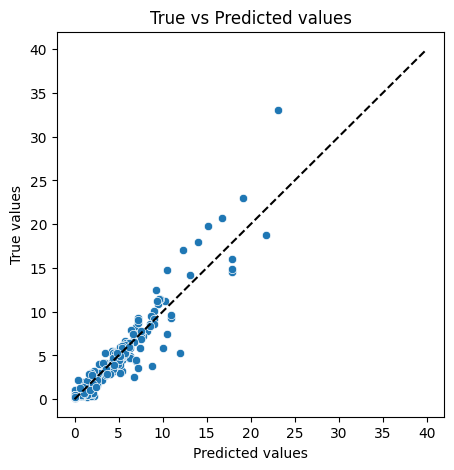

In [64]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

y_train_preds = lr_model.predict(X_train)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

evaluate_preds(Y_train, y_train_preds)

R2:	0.896
RMSE:	1.704
MSE:	2.903


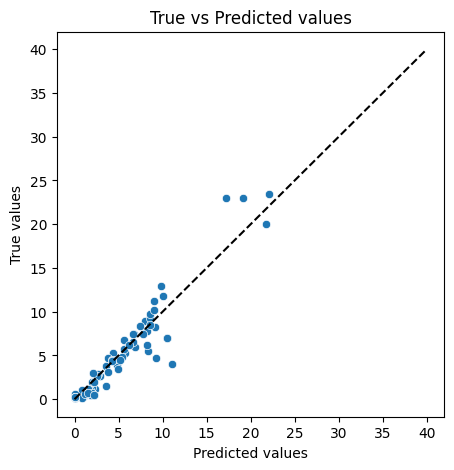

In [65]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

evaluate_preds(Y_test, y_test_preds)

Неплохо, добавим полиномиальное перемножение

In [66]:
from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(
    DataPipeline(),
    StandardScaler(),
    SimpleImputer(strategy='median'),
    PolynomialFeatures(interaction_only=True),
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True))])

In [67]:
X = df.drop(columns='Selling_Price')
Y = df['Selling_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)
pipe.fit(X_train, Y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

R2:	0.974
RMSE:	0.743
MSE:	0.552


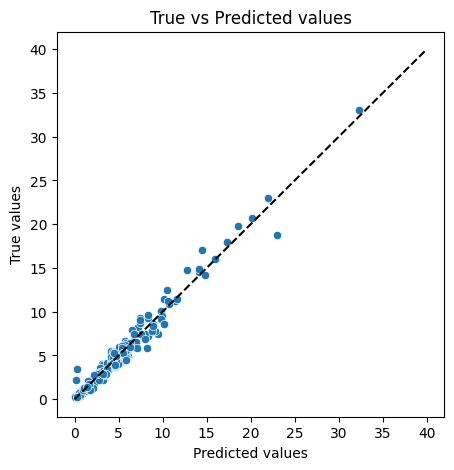

In [68]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

y_train_preds = lr_model.predict(X_train)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

evaluate_preds(Y_train, y_train_preds)

R2:	0.963
RMSE:	1.012
MSE:	1.024


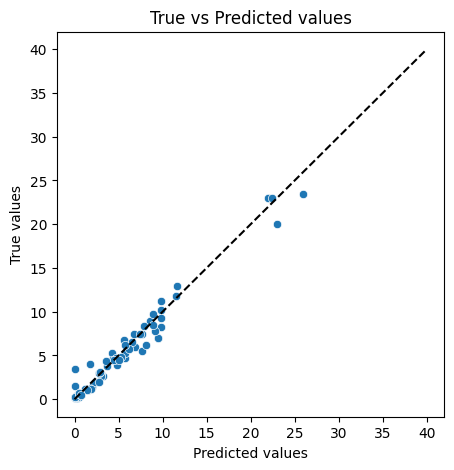

In [69]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

evaluate_preds(Y_test, y_test_preds)

Полиномиальное перемножение дало значительный буст нашей модели, пока сохраним ее. Но эксперименты продолжим

In [70]:
def save_model(lr_model):
    """Функция для сохранения версии модели."""
    with open("linear_model_2.pkl", 'wb') as filename:
        pickle.dump(lr_model, filename)

save_model(lr_model)

Добавим степень полинома

In [71]:
def cross_check(n: int = 1, cols: list = ['Selling_Price']):
    """Функция для кросс-валидации полиномиальных перемножений"""

    pipe = make_pipeline(
        DataPipeline(),
        StandardScaler(),
        SimpleImputer(strategy='median'),
        PolynomialFeatures(degree=n),
    )
    pipe

    X = df.drop(columns=cols)
    Y = df['Selling_Price']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)
    pipe.fit(X_train, Y_train)

    X_train = pipe.transform(X_train)
    X_test = pipe.transform(X_test)

    lr_model = LinearRegression()
    lr_model.fit(X_train, Y_train)

    y_train_preds = lr_model.predict(X_train)
    y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

    evaluate_preds(Y_train, y_train_preds)

    y_test_preds = lr_model.predict(X_test)
    y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

    evaluate_preds(Y_test, y_test_preds)

    return lr_model

R2:	0.978
RMSE:	0.684
MSE:	0.468


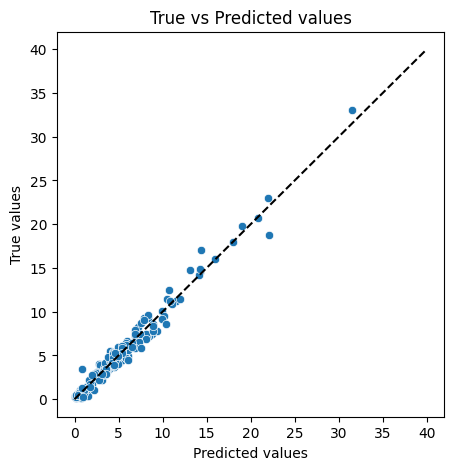

R2:	0.976
RMSE:	0.823
MSE:	0.678


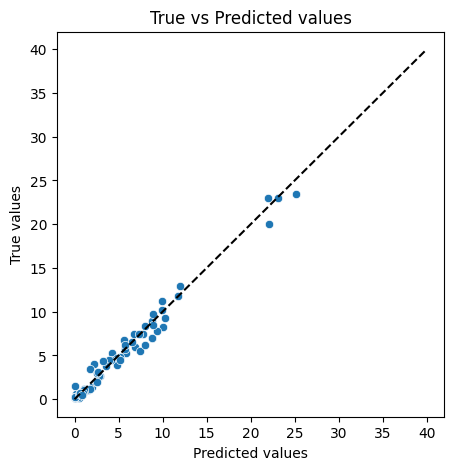

In [72]:
lr_model = cross_check(2)

Шок, но результат стал даже лучше! Перезапишем модель. Попробуем третью степень (очень может быть, что поймаем переобучение)

In [73]:
save_model(lr_model)

R2:	0.987
RMSE:	0.532
MSE:	0.283


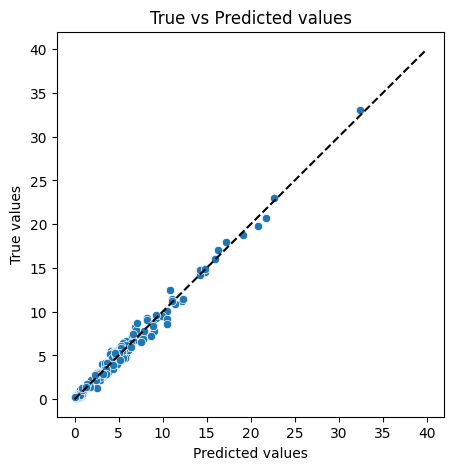

R2:	0.979
RMSE:	0.765
MSE:	0.585


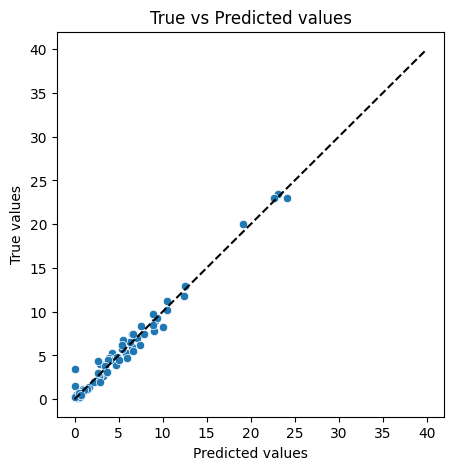

In [74]:
lr_model = cross_check(3)

Неожиданно, но стало еще лучше. Рискнем поставить 4 степень (будет ли на курсе показано, как более оптимально проводить такую кросс-валидацию?)

In [75]:
save_model(lr_model)

R2:	0.99
RMSE:	0.454
MSE:	0.206


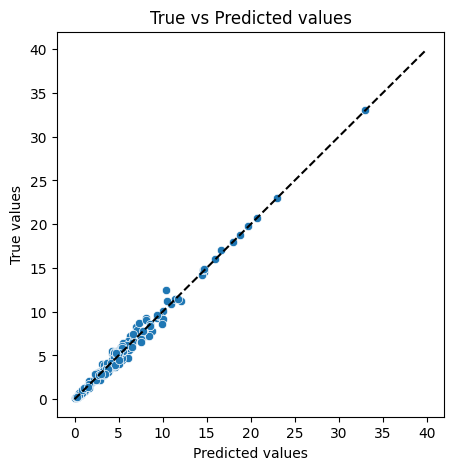

R2:	0.059
RMSE:	5.12
MSE:	26.212


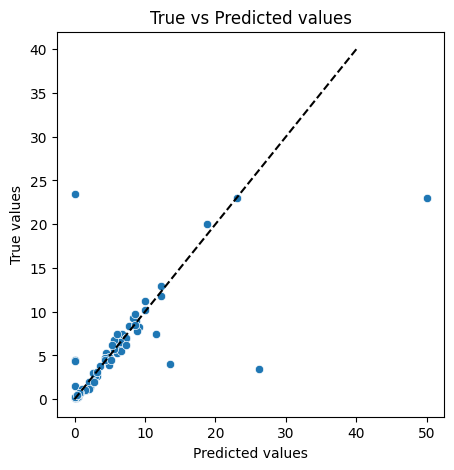

LinearRegression()

In [76]:
cross_check(4)

Переобучились, делаем вывод о том, что оптимальная степень - 3

Попробуем сделать то, как было указано в задании, удалим категориальные признаки

R2:	0.971
RMSE:	0.775
MSE:	0.6


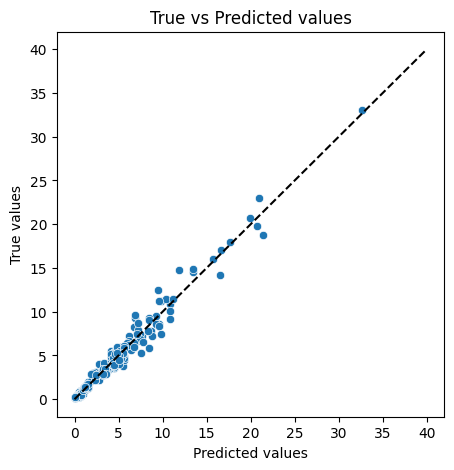

R2:	0.97
RMSE:	0.915
MSE:	0.837


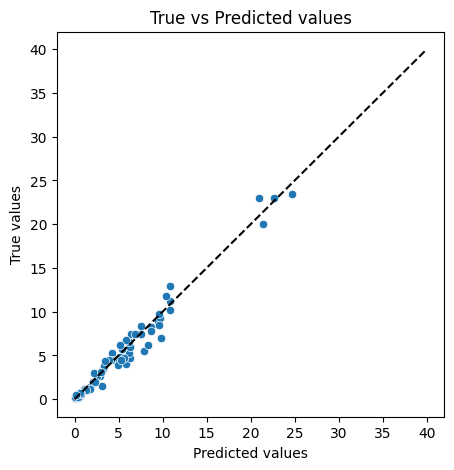

LinearRegression()

In [77]:
cols = ['Selling_Price', 'Fuel_Type', 'Seller_Type', 'Transmission']
cross_check(3, cols)

Неплохо, близко к тому, что получили с учетом категориальных признаков.

Таким образом, мы учли категориальные признаки вместе с количественными и обучили модель линейной регрессии. В ходе кросс-валидации подобрали оптимальное значение параметра степени полинома - 3.

Итоговые метрики и графики

R2:	0.987
RMSE:	0.532
MSE:	0.283


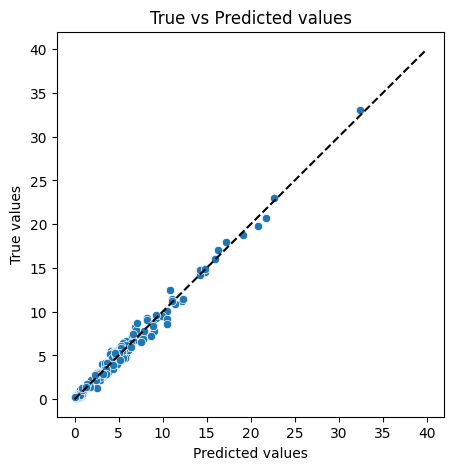

R2:	0.979
RMSE:	0.765
MSE:	0.585


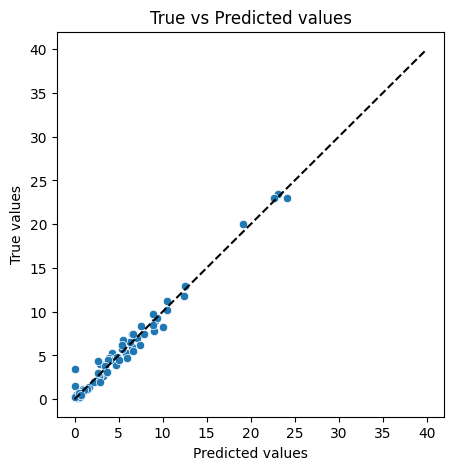

In [78]:
lr_model = cross_check(3)

In [79]:
save_model(lr_model)